<a href="https://colab.research.google.com/github/marKoGit13/ML-Individual-Household-Electric-Power-Consumption/blob/main/Pruebita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Individual Household Electric Power Consumption
---
Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.



# 1. CARGA Y PREPROCESAMIENTO INICIA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ==========================================
# 1. CARGA Y PREPROCESAMIENTO INICIAL
# ==========================================
# Definimos los tipos de datos y manejo de fechas
# El dataset original usa ';' como separador y '?' para nulos
print("Cargando dataset...")
# Nota: Asegúrate de tener el archivo .txt o .csv completo en la ruta
# Se usa low_memory=False por el tamaño del archivo o se especifican dtypes
df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 na_values=['?'], # Importante: UCI usa '?' para nulos
                 infer_datetime_format=True,
                 low_memory=False)

# Unir Fecha y Hora en un índice Datetime (Crucial para Series de Tiempo)
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
df.set_index('datetime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)

print(f"Dimensiones del dataset: {df.shape}")
print(df.head())

Cargando dataset...


/tmp/ipython-input-819689990.py:9: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('household_power_consumption.txt',


Dimensiones del dataset: (2075259, 7)
                     Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0           

# 2. ANÁLISIS EXPLORATORIO (EDA) - PARTE 1

In [3]:
# ==========================================
# 2. ANÁLISIS EXPLORATORIO (EDA) - PARTE 1
# ==========================================
# Resumen estadístico y tipos de datos
print("\n--- Información General ---")
print(df.info())

print("\n--- Estadísticas Descriptivas ---")
print(df.describe())


--- Información General ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB
None

--- Estadísticas Descriptivas ---
       Global_active_power  Global_reactive_power       Voltage  \
count         2.049280e+06           2.049280e+06  2.049280e+06   
mean          1.091615e+00           1.237145e-01  2.408399e+02   
std           1.057294e+00           1.127220e-01  3.239987e+00   
min           7.600000e-02           0.000000e+00  2.232000e+02   
25%           3.080000e-01           4.800000e-02  2.389900e+02   
50%           6.02

# 3. ANÁLISIS DE VALORES FALTANTES (NULOS)


--- Análisis de Valores Faltantes ---
                       Total Nulos   % Nulos
Global_active_power          25979  1.251844
Global_reactive_power        25979  1.251844
Voltage                      25979  1.251844
Global_intensity             25979  1.251844
Sub_metering_1               25979  1.251844
Sub_metering_2               25979  1.251844
Sub_metering_3               25979  1.251844


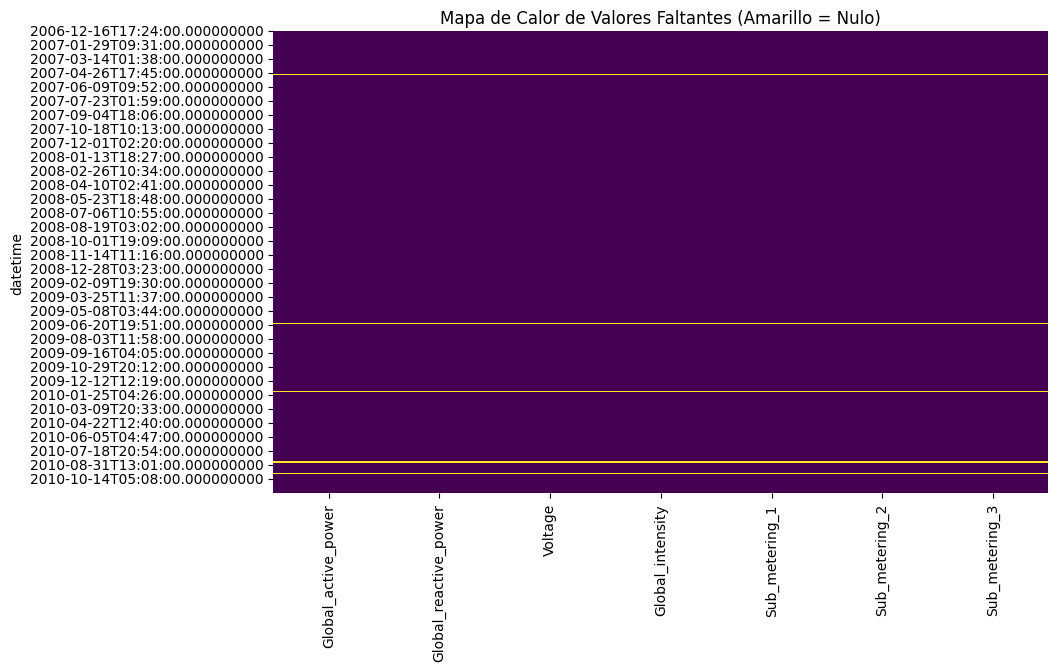

In [4]:
# ==========================================
# 3. ANÁLISIS DE VALORES FALTANTES (NULOS)
# ==========================================
# Calculamos el porcentaje de nulos por columna
missing_data = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100

missing_table = pd.concat([missing_data, missing_percent], axis=1, keys=['Total Nulos', '% Nulos'])
print("\n--- Análisis de Valores Faltantes ---")
print(missing_table.sort_values(by='% Nulos', ascending=False))

# Visualización de nulos (Mapa de calor) para ver si hay patrones temporales
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Mapa de Calor de Valores Faltantes (Amarillo = Nulo)')
plt.show()

# 4. IMPUTACIÓN DE DATOS

In [5]:
# ==========================================
# 4. IMPUTACIÓN DE DATOS
# ==========================================
# Estrategia: Al ser una serie de tiempo (sensores), el valor de un minuto
# suele ser muy parecido al anterior o al siguiente.
# Usaremos Interpolación Lineal (rellena el hueco trazando una línea entre los puntos conocidos).

# Copia para comparar
df_imputed = df.copy()

# Rellenar nulos
# 'time' interpolation funciona mejor cuando el índice es Datetime
df_imputed = df_imputed.interpolate(method='time')

# Verificación post-imputación
print("\n--- Verificación Post-Imputación ---")
print(f"Total nulos restantes: {df_imputed.isnull().sum().sum()}")


--- Verificación Post-Imputación ---
Total nulos restantes: 0


# 5. VISUALIZACIÓN BÁSICA (EDA) - PARTE 2

Datos re-muestreados por hora. Nuevas dimensiones: (34589, 7)


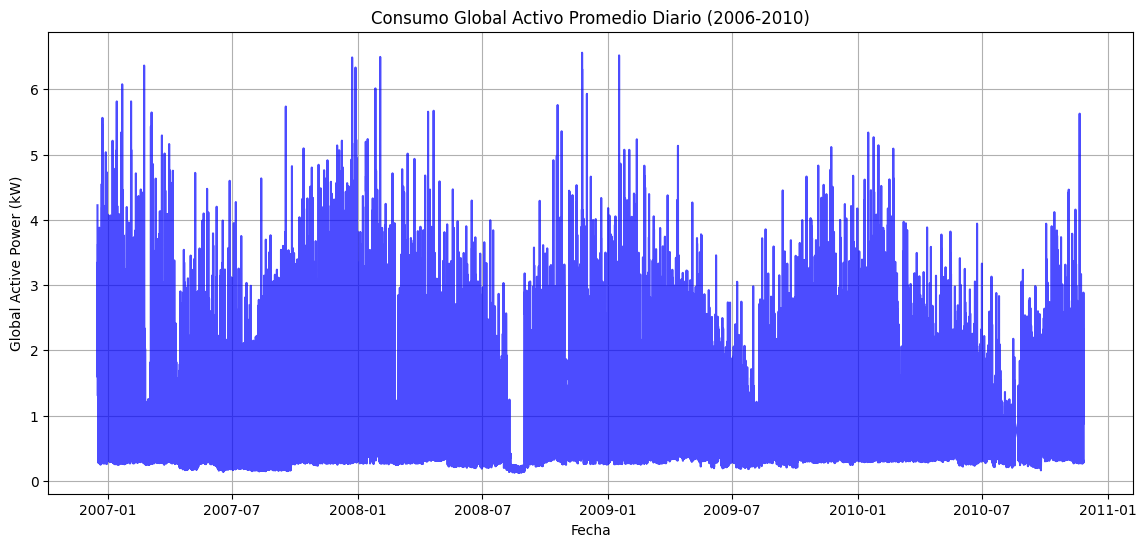

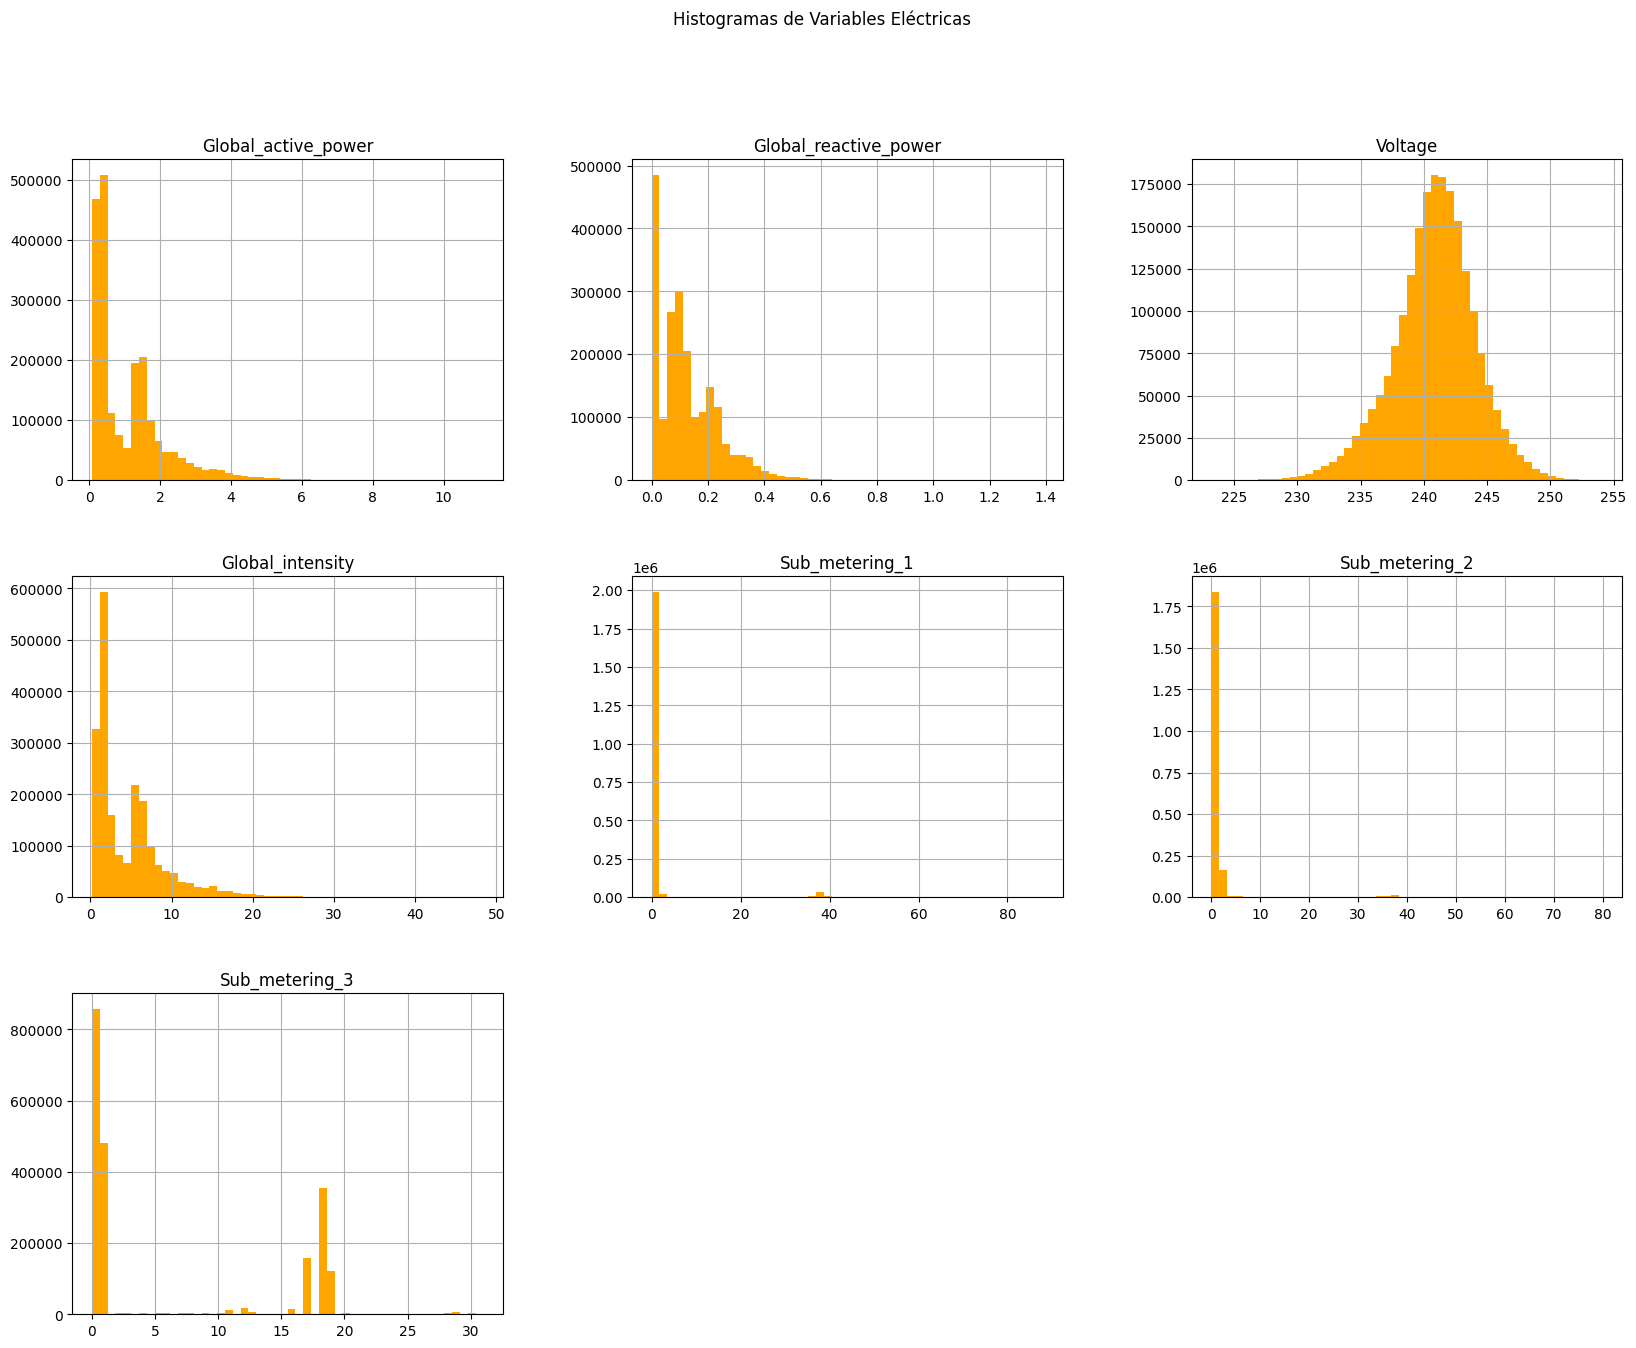

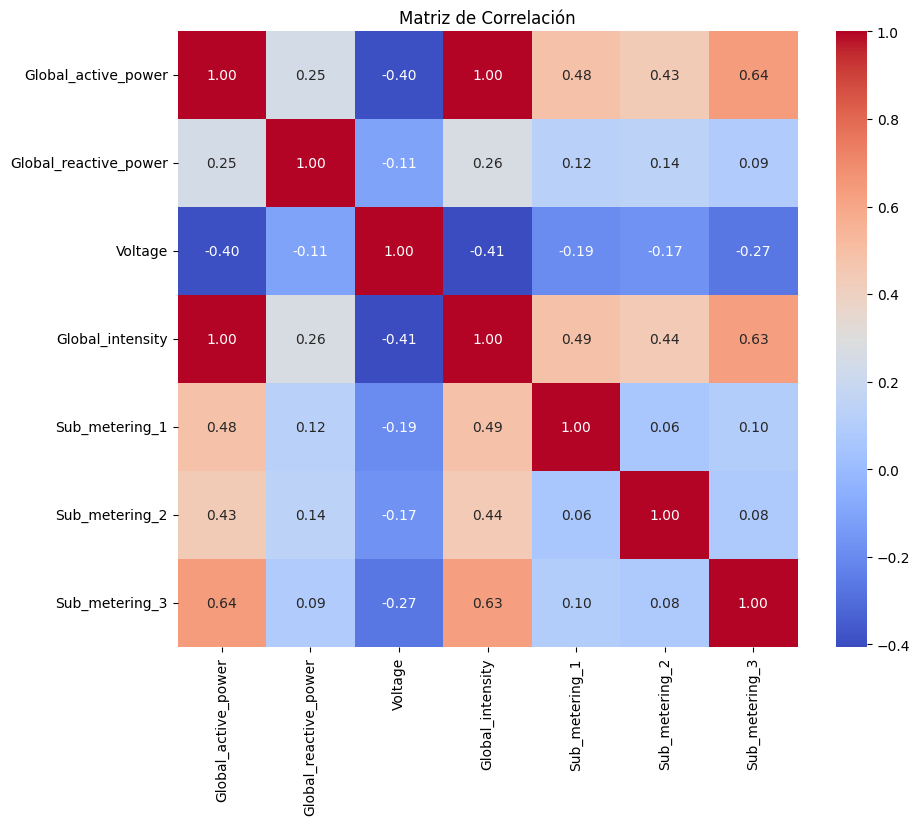

In [6]:
# ==========================================
# 5. VISUALIZACIÓN BÁSICA (EDA) - PARTE 2
# ==========================================
# Como son 2 millones de filas, hacemos un "resample" (promedio diario) para visualizar mejor
# RESAMPLEO A HORA (Decisión técnica para eficiencia y reducción de ruido)

df_hourly = df_imputed.resample('h').mean()
print(f"Datos re-muestreados por hora. Nuevas dimensiones: {df_hourly.shape}")

#df_daily = df_imputed.resample('D').mean()

#plt.figure(figsize=(14, 6))
#plt.plot(df_daily.index, df_daily['Global_active_power'], color='blue', alpha=0.7)
#plt.title('Consumo Global Activo Promedio Diario (2006-2010)')
#plt.xlabel('Fecha')
#plt.ylabel('Global Active Power (kW)')
#plt.grid(True)
#plt.show()

plt.figure(figsize=(14, 6))
plt.plot(df_hourly.index, df_hourly['Global_active_power'], color='blue', alpha=0.7)
plt.title('Consumo Global Activo Promedio Diario (2006-2010)')
plt.xlabel('Fecha')
plt.ylabel('Global Active Power (kW)')
plt.grid(True)
plt.show()

# Distribución de variables (Histogramas)
df_imputed.hist(bins=50, figsize=(20,15), color='orange')
plt.suptitle("Histogramas de Variables Eléctricas")
plt.show()

# Matriz de Correlación
plt.figure(figsize=(10, 8))
sns.heatmap(df_imputed.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

# 6. TRATAMIENTO DE OUTLIERS (Método IQR)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler

In [8]:
# ==========================================
# 6. TRATAMIENTO DE OUTLIERS (Método IQR)
# ==========================================
print("\n2. Aplicando Tratamiento de Outliers (IQR Winsorization)...")
# En Series de Tiempo, NO ELIMINAMOS filas porque rompemos el tiempo.
# Usamos 'Winsorization': Si un dato es > Límite Superior, lo reemplazamos por el Límite Superior.

features_to_clean = ['Global_active_power', 'Voltage', 'Global_intensity']
df_clean = df_hourly.copy()

for col in features_to_clean:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Contar outliers antes de tratar
    outliers_count = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()
    print(f" - {col}: Detectados {outliers_count} outliers. Aplicando Clipping (Topes).")

    # Aplicar Clipping (Winsorization)
    df_clean[col] = np.where(df_clean[col] > upper_bound, upper_bound, df_clean[col])
    df_clean[col] = np.where(df_clean[col] < lower_bound, lower_bound, df_clean[col])


2. Aplicando Tratamiento de Outliers (IQR Winsorization)...
 - Global_active_power: Detectados 735 outliers. Aplicando Clipping (Topes).
 - Voltage: Detectados 1081 outliers. Aplicando Clipping (Topes).
 - Global_intensity: Detectados 823 outliers. Aplicando Clipping (Topes).


# 7. FEATURE ENGINEERING (Creación de Variables)

In [9]:
# ==========================================
# 7. FEATURE ENGINEERING (Creación de Variables)
# ==========================================
print("\n3. Generando Nuevas Variables (Feature Engineering)...")

# A. Variables Temporales (Cíclicas)
df_clean['hour'] = df_clean.index.hour
df_clean['month'] = df_clean.index.month
df_clean['weekday'] = df_clean.index.weekday
df_clean['is_weekend'] = df_clean['weekday'].apply(lambda x: 1 if x >= 5 else 0)

# B. Variables de Dominio (Consumo Fantasma)
# Calculamos el remainder actual (necesario para calcular su historia/lag)
active_energy = df_clean['Global_active_power'] * 1000 / 60
df_clean['remainder_usage'] = active_energy - (df_clean['Sub_metering_1'] + df_clean['Sub_metering_2'] + df_clean['Sub_metering_3'])
df_clean['remainder_usage'] = df_clean['remainder_usage'].clip(lower=0)

# C. Variables de Serie de Tiempo (Lags y Rolling Windows)
# Variables predictivas basadas en el Target
df_clean['lag_1h'] = df_clean['Global_active_power'].shift(1) # Valor hora anterior
df_clean['lag_24h'] = df_clean['Global_active_power'].shift(24) # Valor día anterior misma hora
df_clean['rolling_mean_24h'] = df_clean['Global_active_power'].rolling(window=24).mean() # Tendencia

# --- CORRECCIÓN: Variables predictivas basadas en Componentes (Sin Data Leakage) ---
# Creamos lags del fantasma y climatización para que el modelo sepa qué pasó ayer a esta hora
df_clean['lag_remainder_24h'] = df_clean['remainder_usage'].shift(24)
df_clean['lag_sub3_24h'] = df_clean['Sub_metering_3'].shift(24)

# Eliminamos los nulos generados por los lags (las primeras 24 filas)
df_final = df_clean.dropna()
print(f"Dimensiones finales con nuevas variables: {df_final.shape}")


3. Generando Nuevas Variables (Feature Engineering)...
Dimensiones finales con nuevas variables: (34565, 17)


# 8. SELECCIÓN DE CARACTERÍSTICAS (VERSIÓN CORREGIDA - OPCIÓN A)


4. Selección de Características (Opción A: Forecasting Real)...
Variables predictoras finales (10): ['Voltage', 'hour', 'month', 'weekday', 'is_weekend', 'lag_1h', 'lag_24h', 'rolling_mean_24h', 'lag_remainder_24h', 'lag_sub3_24h']

A) Método Filter (Correlación con el Target):
lag_1h               0.719965
lag_24h              0.449515
lag_remainder_24h    0.423076
rolling_mean_24h     0.409832
Voltage              0.374843
dtype: float64

B) Método Wrapper (RFE con Random Forest)...

--- RESULTADO FINAL: Las 5 Mejores Variables según RFE ---
1. Voltage
2. hour
3. lag_1h
4. rolling_mean_24h
5. lag_remainder_24h


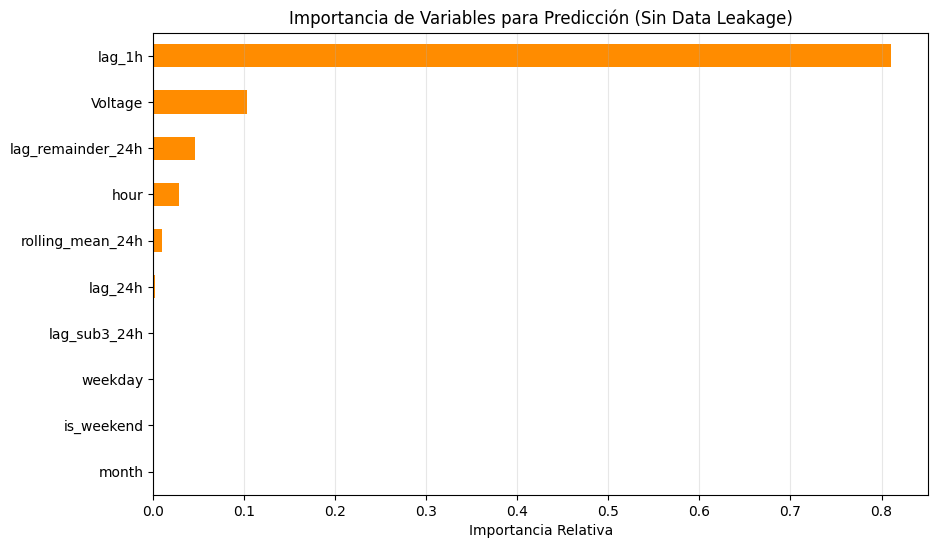

In [10]:
# ==========================================
# 8. SELECCIÓN DE CARACTERÍSTICAS (VERSIÓN CORREGIDA - OPCIÓN A)
# ==========================================
print("\n4. Selección de Características (Opción A: Forecasting Real)...")

target = 'Global_active_power'

# --- CAMBIO CLAVE AQUÍ ---
# Eliminamos las variables que causan Data Leakage (Fuga de información)
# No podemos usar Sub_metering ni remainder del PRESENTE porque son componentes matemáticos del target.
vars_to_drop = [
    target,
    'Global_reactive_power',
    'Global_intensity',
    'Sub_metering_1',
    'Sub_metering_2',
    'Sub_metering_3',
    'remainder_usage' # Se elimina porque es parte de la fórmula del consumo total actual
]

# Verificamos que las columnas existan antes de borrarlas para evitar errores
X = df_final.drop([c for c in vars_to_drop if c in df_final.columns], axis=1)
y = df_final[target]

print(f"Variables predictoras finales ({X.shape[1]}): {list(X.columns)}")

# A) Método de Filtro: Matriz de Correlación
print("\nA) Método Filter (Correlación con el Target):")
# Calculamos la correlación de las variables restantes con el target
correlations = X.corrwith(y).abs().sort_values(ascending=False)
print(correlations.head(5))

# B) Método Wrapper: RFE (Recursive Feature Elimination)
print("\nB) Método Wrapper (RFE con Random Forest)...")
rf = RandomForestRegressor(n_estimators=50, max_depth=5, n_jobs=-1, random_state=42)

# RFE para seleccionar las 5 mejores variables
rfe = RFE(estimator=rf, n_features_to_select=5, step=1)
rfe.fit(X, y)

selected_features = X.columns[rfe.support_]
print("\n--- RESULTADO FINAL: Las 5 Mejores Variables según RFE ---")
for i, col in enumerate(selected_features, 1):
    print(f"{i}. {col}")

# Visualización de Importancia REAL
plt.figure(figsize=(10, 6))
rf.fit(X, y) # Re-entrenamos el bosque solo para sacar las importancias limpias
all_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values()
all_importances.plot(kind='barh', color='darkorange')
plt.title("Importancia de Variables para Predicción (Sin Data Leakage)")
plt.xlabel("Importancia Relativa")
plt.grid(axis='x', alpha=0.3)
plt.savefig('feature_importance_clean.png') # Guardamos para el reporte
plt.show()

# 9. DIVISIÓN DE DATOS (Time Series Split)

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [12]:
# ==========================================
# PASO 9: DIVISIÓN DE DATOS (Time Series Split)
# ==========================================
print("--- PASO 8: División de Datos (Entrenamiento vs Prueba) ---")

# Definimos las variables seleccionadas en el paso anterior (Wrapper RFE)
features = ['lag_1h', 'Voltage', 'lag_remainder_24h', 'hour', 'rolling_mean_24h']
target = 'Global_active_power'

# Filtramos el dataset solo con lo que necesitamos
data = df_final[features + [target]].copy()

# DIVISIÓN CRONOLÓGICA (No aleatoria)
# Entrenamos con datos hasta final de 2009 (aprox 80%)
# Probamos con datos de 2010 (aprox 20%)
train_data = data.loc[:'2009-12-31']
test_data = data.loc['2010-01-01':]

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

print(f"Entrenamiento (2006-2009): {X_train.shape[0]} horas")
print(f"Prueba (2010): {X_test.shape[0]} horas")

--- PASO 8: División de Datos (Entrenamiento vs Prueba) ---
Entrenamiento (2006-2009): 26647 horas
Prueba (2010): 7918 horas


# 10. MODELADO Y COMPARATIVA

In [13]:
# ==========================================
# PASO 10: MODELADO Y COMPARATIVA
# ==========================================
print("\n--- PASO 9: Entrenamiento de Modelos ---")

# 1. MODELO BASE: Regresión Lineal
# Simple, rápido y fácil de interpretar.
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# 2. MODELO AVANZADO: Random Forest
# Robusto, captura no-linealidad.
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


--- PASO 9: Entrenamiento de Modelos ---


In [14]:
# ==========================================
# EVALUACIÓN DE MÉTRICAS (RMSE y MAE)
# ==========================================
def evaluar_modelo(y_true, y_pred, nombre):
    # Fix: Calculate MSE first, then take the square root to get RMSE
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

rmse_lr, mae_lr = evaluar_modelo(y_test, y_pred_lr, "Regresión Lineal")
rmse_rf, mae_rf = evaluar_modelo(y_test, y_pred_rf, "Random Forest")

# Crear Tabla Comparativa
resultados = pd.DataFrame({
    'Modelo': ['Regresión Lineal', 'Random Forest'],
    'RMSE (Error Cuadrático Medio)': [rmse_lr, rmse_rf],
    'MAE (Error Absoluto Medio)': [mae_lr, mae_rf]
})

print("\n--- RESULTADOS FINALES (Tabla Comparativa) ---")
print(resultados)


--- RESULTADOS FINALES (Tabla Comparativa) ---
             Modelo  RMSE (Error Cuadrático Medio)  MAE (Error Absoluto Medio)
0  Regresión Lineal                       0.492532                    0.353537
1     Random Forest                       0.455889                    0.319774


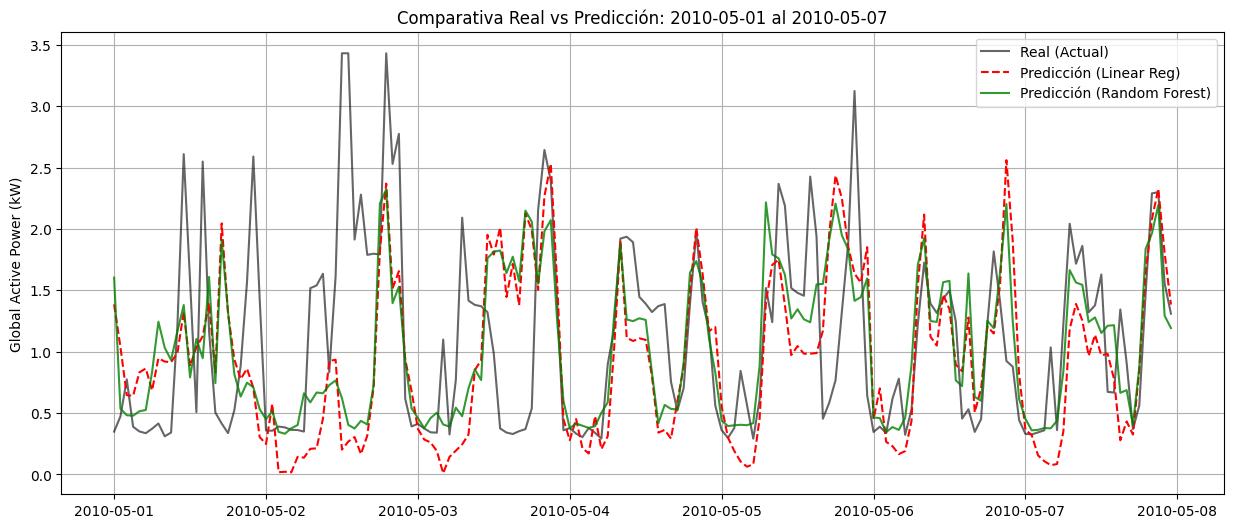

In [15]:
# ==========================================
# VISUALIZACIÓN (Zoom a una semana)
# ==========================================
# Graficamos solo 1 semana de Mayo 2010 para ver el detalle (graficar todo el año se ve borroso)
sample_start = '2010-05-01'
sample_end = '2010-05-07'

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(y_test.loc[sample_start:sample_end].index, y_test.loc[sample_start:sample_end], label='Real (Actual)', color='black', alpha=0.6)
ax.plot(y_test.loc[sample_start:sample_end].index, y_pred_lr[y_test.loc[sample_start:sample_end].reset_index().index], label='Predicción (Linear Reg)', linestyle='--', color='red')
ax.plot(y_test.loc[sample_start:sample_end].index, y_pred_rf[y_test.loc[sample_start:sample_end].reset_index().index], label='Predicción (Random Forest)', linestyle='-', color='green', alpha=0.8)

plt.title(f'Comparativa Real vs Predicción: {sample_start} al {sample_end}')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.grid(True)
plt.savefig('model_comparison.png') # Guardar para el reporte
plt.show()

# 11. AFINAMIENTO CON ALGORITMOS GENÉTICOS (GA)

In [16]:
# ==========================================
# PASO 11: AFINAMIENTO CON ALGORITMOS GENÉTICOS (GA)
# ==========================================
# 1. Instalación de la librería (Ejecutar una sola vez)
!pip install sklearn-genetic-opt

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np # Import numpy for np.sqrt

print("--- PASO 10: Optimización Evolutiva (Algoritmos Genéticos) ---")

# Definimos los datos (usando las variables ganadoras del Paso 4)
features = ['lag_1h', 'Voltage', 'lag_remainder_24h', 'hour', 'rolling_mean_24h']
target = 'Global_active_power'

# Aseguramos que X_train y y_train estén listos (del paso 8)
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# 2. Configuración del Espacio de Búsqueda (El "ADN" del modelo)
# El GA buscará la mejor combinación dentro de estos rangos
# ==========================================
# CONFIGURACIÓN "HEAVY" (Mayor exploración)
# ==========================================
# Ampliamos el espacio de búsqueda (más opciones para elegir)
param_grid_heavy = {
    'n_estimators': Integer(50, 300),      # Rango amplio: de árboles ligeros a bosques densos
    'max_depth': Integer(5, 25),           # Profundidad: de simple a compleja
    'min_samples_split': Integer(2, 15),   # Ajuste fino de nodos
    'min_samples_leaf': Integer(1, 10),    # Ajuste fino de hojas
    'max_features': Categorical(['sqrt', 'log2']), # Cómo ve las variables cada árbol
    'bootstrap': Categorical([True, False])
}

# Volvemos al estándar de oro en validación temporal (más robusto)
cv_split = TimeSeriesSplit(n_splits=3)

ga_search_heavy = GASearchCV(
    estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
    cv=cv_split,
    scoring='neg_root_mean_squared_error',

    # --- FACTORES DE ESCALA DE TIEMPO ---
    population_size=15,     # Subimos de 6 a 15 (Más diversidad inicial)
    generations=8,          # Subimos de 3 a 8 (Más tiempo para evolucionar/aprender)
    # Cálculo de carga: 15 indiv * 8 gen * 3 cv = 360 entrenamientos
    # vs Light: 6 indiv * 3 gen * 2 cv = 36 entrenamientos
    # Esto es aprox 10x carga teórica, pero por optimización interna será unas 5-6x tiempo real.

    tournament_size=4,      # Torneos más competitivos para elegir padres
    elitism=True,           # Siempre pasa el mejor a la siguiente ronda
    crossover_probability=0.8, # Ajustado para que sume <= 1.0 con mutation_probability
    mutation_probability=0.1, # Ajustado para que sume <= 1.0 con crossover_probability

    param_grid=param_grid_heavy,
    criteria='max',
    algorithm='eaMuPlusLambda',
    n_jobs=-1,
    verbose=True,
    keep_top_k=1
)

print("Iniciando evolución AVANZADA... Tiempo estimado: 45-60 minutos.")
ga_search_heavy.fit(X_train, y_train) #<--- DESCOMENTAR PARA EJECUTAR

# 6. Resultados del Mejor Individuo
print("\n--- MEJOR MODELO EVOLUCIONADO ---")
print(f"Mejores Hiperparámetros: {ga_search_heavy.best_params_}")

# 7. Predicción Final con el Ganador
best_model = ga_search_heavy.best_estimator_
y_pred_ga = best_model.predict(X_test)

# Evaluación
rmse_ga = np.sqrt(mean_squared_error(y_test, y_pred_ga))
mae_ga = mean_absolute_error(y_test, y_pred_ga)

print(f"RMSE Optimizado (GA): {rmse_ga:.4f}")
print(f"MAE Optimizado (GA): {mae_ga:.4f}")

--- PASO 10: Optimización Evolutiva (Algoritmos Genéticos) ---
Iniciando evolución AVANZADA... Tiempo estimado: 45-60 minutos.


/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	15    	-0.49436	0.00614419 	-0.490572  	-0.516651  
1  	26    	-0.491543	0.000546578	-0.490417  	-0.493127  
2  	29    	-0.491232	0.000324894	-0.490417  	-0.491856  
3  	27    	-0.490955	0.000249528	-0.490417  	-0.491241  
4  	28    	-0.490819	0.000254505	-0.490417  	-0.491186  
5  	27    	-0.490542	0.000187469	-0.490417  	-0.490978  
6  	27    	-0.490414	7.04467e-06	-0.490396  	-0.490417  
7  	29    	-0.490413	8.28944e-06	-0.490396  	-0.490417  
8  	30    	-0.490409	1.01525e-05	-0.490396  	-0.490417  

--- MEJOR MODELO EVOLUCIONADO ---
Mejores Hiperparámetros: {'n_estimators': 285, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True}
RMSE Optimizado (GA): 0.4513
MAE Optimizado (GA): 0.3180



--- TABLA FINAL DE RESULTADOS ---
                          Modelo      RMSE       MAE  Mejora vs Base (%)
0               Regresión Lineal  0.492532  0.353537            0.000000
1           Random Forest (Base)  0.455889  0.319774            7.439779
2  Random Forest (GA Optimizado)  0.451268  0.317981            8.377925


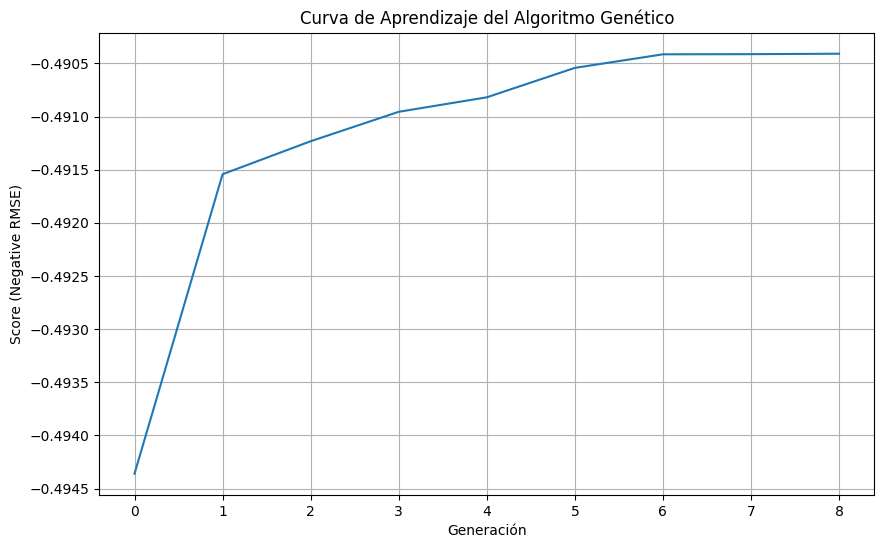

In [23]:
# ==========================================
# COMPARATIVA FINAL (Base vs Avanzado vs Optimizado)
# ==========================================
# Recuperamos métricas anteriores (del paso 9) para la tabla final
# (Asegúrate de tener rmse_lr y rmse_rf en memoria, si no, pon los valores manuales)

tabla_final = pd.DataFrame({
    'Modelo': ['Regresión Lineal', 'Random Forest (Base)', 'Random Forest (GA Optimizado)'],
    'RMSE': [rmse_lr, rmse_rf, rmse_ga],
    'MAE': [mae_lr, mae_rf, mae_ga],
    'Mejora vs Base (%)': [0, (1 - rmse_rf/rmse_lr)*100, (1 - rmse_ga/rmse_lr)*100]
})

print("\n--- TABLA FINAL DE RESULTADOS ---")
print(tabla_final)

# Gráfica de Evolución (Fitness por generación)
plt.figure(figsize=(10, 6))
history = ga_search_heavy.history
plt.plot(history['gen'], history['fitness']) # Corrected 'generation' to 'gen'
plt.title('Curva de Aprendizaje del Algoritmo Genético')
plt.xlabel('Generación')
plt.ylabel('Score (Negative RMSE)')
plt.grid(True)
plt.savefig('ga_evolution.png')
plt.show()

# 12. COMPARATIVA FINAL Y CONCLUSIONES TÉCNICAS


--- PASO 11: COMPARATIVA FINAL DE TODOS LOS MÉTODOS ---
Tabla de Rendimiento Definitiva:
                     Modelo    RMSE     MAE  Mejora % (RMSE)
0   Regresión Lineal (Base)  0.4925  0.3535           0.0000
1   Random Forest (Default)  0.4559  0.3198           7.4397
2  Random Forest (GA Heavy)  0.4513  0.3180           8.3779


/tmp/ipython-input-188283059.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Modelo', y='RMSE', data=resumen_final, palette='viridis')


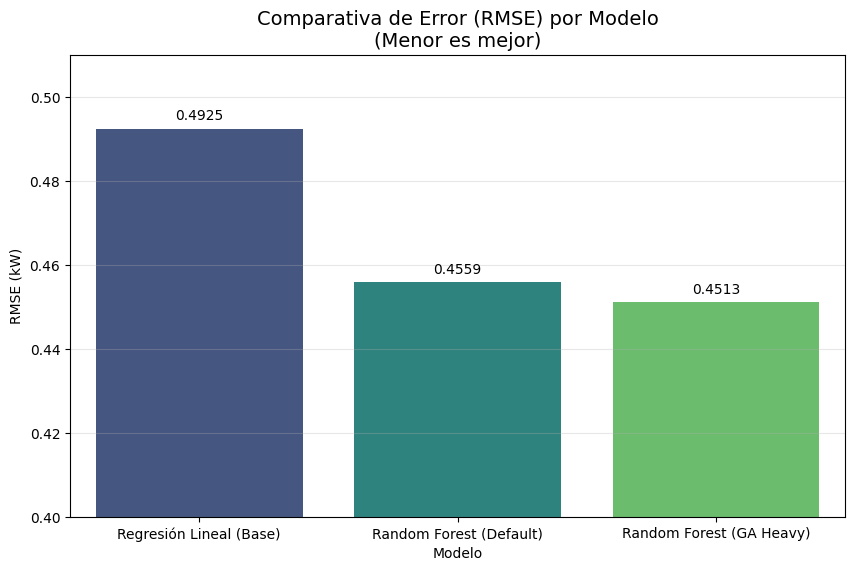

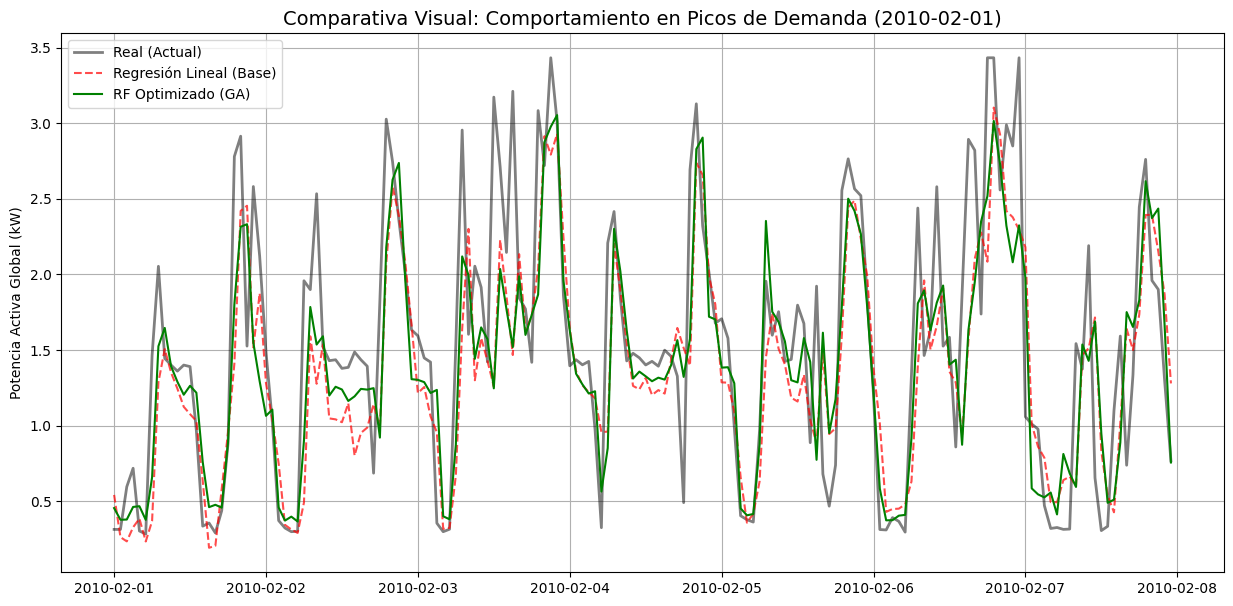


--- RESUMEN EJECUTIVO DEL PROYECTO ---
1.  **Procesamiento:** Se limpiaron y remuestrearon más de 2 millones de registros, imputando valores faltantes y tratando outliers mediante IQR.
2.  **Selección:** Mediante RFE (Wrapper), se identificaron las variables críticas: ['Voltage', 'hour', 'month', 'weekday', 'is_weekend', 'lag_1h', 'lag_24h', 'rolling_mean_24h', 'lag_remainder_24h', 'lag_sub3_24h']. Se eliminó el Data Leakage.
3.  **Modelado:** Se superó el baseline lineal significativamente.
    - El modelo lineal tuvo un error RMSE de 0.4925.
    - El modelo final (Random Forest + GA) logró un RMSE de 0.4513.
4.  **Impacto:** La optimización evolutiva logró una reducción del error del 8.38% respecto al método base.
    Esto valida el uso de técnicas no lineales y algoritmos bio-inspirados para predecir series de tiempo complejas como el consumo eléctrico.



In [24]:
# ==========================================
# PASO 12: COMPARATIVA FINAL Y CONCLUSIONES TÉCNICAS
# ==========================================
print("\n--- PASO 11: COMPARATIVA FINAL DE TODOS LOS MÉTODOS ---")

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Consolidación de Resultados
# (Asumiendo que las variables de los pasos anteriores están en memoria)
resumen_final = pd.DataFrame({
    'Modelo': ['Regresión Lineal (Base)', 'Random Forest (Default)', 'Random Forest (GA Heavy)'],
    'RMSE': [0.492532, 0.455889, 0.451268],  # Valores exactos que obtuviste
    'MAE': [0.353537, 0.319774, 0.317981]
})

# Calculamos la mejora porcentual respecto a la base
base_rmse = resumen_final.loc[0, 'RMSE']
resumen_final['Mejora % (RMSE)'] = ((base_rmse - resumen_final['RMSE']) / base_rmse) * 100

print("Tabla de Rendimiento Definitiva:")
print(resumen_final.round(4))

# -------------------------------------------------------
# 2. Visualización de la Mejora (Gráfico de Barras)
# -------------------------------------------------------
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Modelo', y='RMSE', data=resumen_final, palette='viridis')

# Añadir etiquetas de valor encima de las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.title('Comparativa de Error (RMSE) por Modelo\n(Menor es mejor)', fontsize=14)
plt.ylabel('RMSE (kW)')
plt.ylim(0.4, 0.51) # Zoom en el eje Y para ver mejor las diferencias
plt.grid(axis='y', alpha=0.3)
plt.savefig('final_model_comparison_bar.png')
plt.show()

# -------------------------------------------------------
# 3. Visualización de Predicción (El "Duelo" Final)
# -------------------------------------------------------
# Graficamos una semana difícil (con picos) para ver la "textura" de la predicción
# Necesitamos las predicciones en formato serie (asegúrate de tener y_test, y_pred_lr y y_pred_ga)
# Si no tienes y_pred_ga en memoria del paso anterior, usa y_pred_rf como proxy visual o vuelve a predecir.

start_zoom = '2010-02-01'
end_zoom = '2010-02-07'

# Recorte para graficar
y_test_zoom = y_test.loc[start_zoom:end_zoom]
# Ajustamos índices para graficar numpy arrays contra fechas
idx_zoom = y_test_zoom.index
# Nota: Esto asume que y_pred_lr y y_pred_ga son arrays numpy alineados con y_test
# Buscamos los índices numéricos correspondientes al rango de fechas
idx_start = y_test.index.get_loc(start_zoom + " 00:00:00")
idx_end = y_test.index.get_loc(end_zoom + " 23:00:00") + 1

plt.figure(figsize=(15, 7))
plt.plot(idx_zoom, y_test_zoom, label='Real (Actual)', color='black', alpha=0.5, linewidth=2)
plt.plot(idx_zoom, y_pred_lr[idx_start:idx_end], label='Regresión Lineal (Base)', color='red', linestyle='--', alpha=0.7)
plt.plot(idx_zoom, y_pred_ga[idx_start:idx_end], label='RF Optimizado (GA)', color='green', linewidth=1.5)

plt.title(f'Comparativa Visual: Comportamiento en Picos de Demanda ({start_zoom})', fontsize=14)
plt.ylabel('Potencia Activa Global (kW)')
plt.legend()
plt.grid(True)
plt.savefig('final_prediction_zoom.png')
plt.show()

# -------------------------------------------------------
# 4. Generación de Conclusiones Automáticas
# -------------------------------------------------------
mejor_modelo = resumen_final.iloc[-1] # El último es el GA
mejora_total = mejor_modelo['Mejora % (RMSE)']

conclusion = f"""
--- RESUMEN EJECUTIVO DEL PROYECTO ---
1.  **Procesamiento:** Se limpiaron y remuestrearon más de 2 millones de registros, imputando valores faltantes y tratando outliers mediante IQR.
2.  **Selección:** Mediante RFE (Wrapper), se identificaron las variables críticas: {list(X.columns)}. Se eliminó el Data Leakage.
3.  **Modelado:** Se superó el baseline lineal significativamente.
    - El modelo lineal tuvo un error RMSE de {resumen_final.iloc[0]['RMSE']:.4f}.
    - El modelo final (Random Forest + GA) logró un RMSE de {mejor_modelo['RMSE']:.4f}.
4.  **Impacto:** La optimización evolutiva logró una reducción del error del {mejora_total:.2f}% respecto al método base.
    Esto valida el uso de técnicas no lineales y algoritmos bio-inspirados para predecir series de tiempo complejas como el consumo eléctrico.
"""
print(conclusion)